In [1]:
#Importing necessary libraries and ignoring warnings and cmdstanpy verbose.

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import pandas as pd
from prophet import Prophet
from datetime import datetime
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np
import warnings
import random
import logging
from itertools import product
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)

C:\Users\adhwa\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def preprocess_tourism_data(df):
    """
    Filters holiday trips, aggregates quarterly data,
    sorts index, and sets frequency
    """

    # Filter for purpose as 'Holiday'
    df = df[df["Purpose"] == "Holiday"]

    # Convert quarter column to datetime
    df["Quarter"] = pd.to_datetime(df["Quarter"])
    
    # Convert trips to integer
    df["Trips"]=df["Trips"].astype(np.int64)
    
    #Sort the data by Quarter
    df.sort_values('Quarter',inplace=True)
    
    # Aggregate trips per quarter
    aggregated_df = (
        df.groupby("Quarter")["Trips"]
        .sum()
        .rename("Trips")
    )


    # Enforce quarterly frequency
    aggregated_df = aggregated_df.asfreq("QS")

    return aggregated_df


In [3]:

def time_series_eda(df, date_col, value_col):
    """
    Performs basic EDA for time series data
    """
    print("Basic Info of the Dataset")
    
    #Print the necessary columns from the dataset
    print(df[[date_col, value_col]].describe())

    print("\n Time Series Plot")
    plt.figure(figsize=(12, 5))
    plt.plot(df[date_col], df[value_col])
    plt.title("Time Series Plot")
    plt.xlabel("Year")
    plt.ylabel(value_col)
    plt.show()

    print("\n Augmented Dickey-Fuller Test")
    # Perform adfuller test on the dataset
    adf_result = adfuller(df[value_col].dropna(), autolag="AIC")
    
    print(f"P-value: {adf_result[1]:.4f}")
    
    # Identify stationarity of the dataset
    
    if adf_result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")


In [4]:
def train_test_split_ts(series, train_size):
    """
    Splits time series into train and test sets
    """
    train = series.iloc[:train_size]
    test = series.iloc[train_size:]
    return train, test


In [5]:
def run_auto_arima(train_data, seasonal=True, m=4):
    """
    Fits auto_arima and returns the fitted model and best parameters
    """
    model = auto_arima(
        train_data,
        seasonal=seasonal,
        m=m,
        suppress_warnings=True,
        error_action="ignore",
        trace=False 
    )
    order = model.order
    seasonal_order = model.seasonal_order
    params = {
        "p": order[0],
        "d": order[1],
        "q": order[2],
        "P": seasonal_order[0],
        "D": seasonal_order[1],
        "Q": seasonal_order[2],
        "s": seasonal_order[3]
    }
    return params


In [21]:

def sarimax_objective(trial):
    
    # Hyperparameter search space
    p = trial.suggest_int("p", 0, 3)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 3)

    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    s = trial.suggest_categorical("s", [4, 12]) # we know it yas yearly seasonlaity i.e 4 quarters in a year so 4 would be the best fit.
    

    model = SARIMAX(
        train_data,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    result = model.fit(disp=False)
    forecast = result.forecast(steps=len(test_data))

    #rmse = np.sqrt(mean_squared_error(test_data, forecast))
    r2=r2_score(test_data, forecast)
    return r2



In [43]:
def prophet_objective(trial):
    
    # Hyperparameter search space
    changepoint_prior_scale = trial.suggest_float(
        "changepoint_prior_scale", 0.01,  0.5, log=True
    )
    seasonality_prior_scale = trial.suggest_float(
        "seasonality_prior_scale", 0.01, 30.0, log=True
    )
    holidays_prior_scale = trial.suggest_float(
        "holidays_prior_scale", 0.01, 1, log=True
    )
    seasonality_mode = trial.suggest_categorical(
        "seasonality_mode", ["additive", "multiplicative"]
    )
    changepoint_range = trial.suggest_float(
        "changepoint_range",0.8,0.9
    )


    train_df = pd.DataFrame({"ds": train_data.index,"y": train_data.values})
    test_df = pd.DataFrame({"ds": test_data.index,"y": test_data.values})

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode,
        changepoint_range=changepoint_range,
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    model.fit(train_df)

    future = model.make_future_dataframe(
        periods=len(test_df),
        freq="QS"
    )

    forecast = model.predict(future)
    y_pred = forecast["yhat"].iloc[-len(test_df):].values

    #rmse = np.sqrt(mean_squared_error(test_df["y"], y_pred))
    r2=r2_score(test_df["y"], y_pred)
    return r2



In [44]:


def prophet_manual_grid_search(
    train_data,
    test_data
):
    """
    Manual grid search for Prophet.
    Selects model with minimum RMSE, tie-breaker = max R2
    """
    base_r2=float('-inf')
    train_df = pd.DataFrame({"ds": train_data.index,"y": train_data.values})
    test_df =pd.DataFrame({"ds": test_data.index,"y": test_data.values})

    results = []
    changepoint_prior_scale=[0.01, 0.03, 0.05]
    seasonality_prior_scale=[0.5, 10.0, 30.0]
    holidays_prior_scale=[0.01,0.5,1]
    seasonality_mode=["multiplicative","additive"]
    changepoint_range=[0.8,0.9]
    for cps in changepoint_prior_scale:
        for sps in seasonality_prior_scale:
            for sm in seasonality_mode:
                for hps in holidays_prior_scale:
                    for cr in changepoint_range:
                    
                        model = Prophet(
                            changepoint_prior_scale=cps,
                            seasonality_prior_scale=sps,
                            seasonality_mode=sm,
                            holidays_prior_scale=hps,
                            changepoint_range=cr,
                            yearly_seasonality=True,
                            weekly_seasonality=False,
                            daily_seasonality=False
                        )

                        # Correct yearly seasonality for quarterly data

                        model.fit(train_df)

                        future = model.make_future_dataframe(
                            periods=len(test_df),
                            freq="QS"
                        )

                        forecast = model.predict(future)
                        y_pred = forecast["yhat"].iloc[-len(test_df):].values
                        rmse = np.sqrt(mean_squared_error(test_df["y"], y_pred))
                        r2 = r2_score(test_df["y"], y_pred)

                        if r2>base_r2:
                            best_params={ "changepoint_prior_scale" :cps,"seasonality_prior_scale":sps,
                            "seasonality_mode":sm,
                            "holidays_prior_scale":hps,
                            "changepoint_range":cr}
                        else:
                            pass


    return y_pred,best_params,rmse,r2


In [9]:

def sarimax_model(train,  test=None, params=None, forecast_periods=None):
    """
    Common SARIMAX training & evaluation function
    params = {
        'p','d','q','P','D','Q','s'
    }
    """

    model = SARIMAX(
        train,
        order=(params["p"], params["d"], params["q"]),
        seasonal_order=(params["P"], params["D"], params["Q"], params["s"]),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
       
    result = model.fit(disp=False)

    # Decide forecast length
    if test is not None:
        steps = len(test)
    elif forecast_periods is not None:
        steps = forecast_periods


    forecast = result.forecast(steps=steps)

    # Evaluate if test data provided
    if test is not None and forecast is not None:
        rmse = np.sqrt(mean_squared_error(test, forecast))
        r2 = r2_score(test, forecast)
        return forecast, rmse, r2
    else:
        return forecast

In [45]:
def prophet_model(train, test=None, params=None, forecast_periods=None):
    """
    Train Prophet model and optionally evaluate or forecast future
    """
    train_df=pd.DataFrame({"ds": train.index,"y": train.values})


    model = Prophet(
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"],
        holidays_prior_scale=params["holidays_prior_scale"],
        seasonality_mode=params["seasonality_mode"],
        changepoint_range=params["changepoint_range"],
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )


    model.fit(train_df)

    # Determine forecast horizon
    if test is not None:
        periods = len(test)
    else:
        periods = forecast_periods

    future = model.make_future_dataframe(
        periods=periods,
        freq="QS"
    )

    forecast = model.predict(future)
    yhat = forecast["yhat"].iloc[-periods:].values

    # Evaluation
    if test is not None:
        rmse = mean_squared_error(test.values, yhat)
        r2 = r2_score(test.values, yhat)
        return yhat, rmse, r2
    else:
        return pd.DataFrame(yhat,columns=['Trips'])


In [27]:
def plot_forecast(train, test=None, forecast=None, future_forecast=None, future_index=None, title="SARIMAX Forecast vs Actuals"):
    """
    Plot historical data, forecast on test, and future unknown forecast.

    Parameters:
    ----------
    train : pd.Series
        Historical training data
    test : pd.Series, optional
        Test data (actuals)
    forecast : pd.Series or np.array, optional
        Forecast corresponding to test data
    future_forecast : np.array, optional
        Forecast for future unknown periods
    future_index : pd.DatetimeIndex, optional
        Index for future forecast periods
    title : str
        Plot title
    """

    plt.figure(figsize=(12, 5))
    
    # Plot train
    plt.plot(train.index, train, label="Train", color="blue")

    # Plot test
    
    plt.plot(test.index, test, label="Test", color="orange")
    
    # Plot grid search forecast on test
    
    plt.plot(test.index, forecast, label="Forecast (Test)", linestyle="--", color="green")
    
    # Plot future unknown forecast
    
    plt.plot(future_index, future_forecast, label="Future Forecast", linestyle="--", color="red")

    plt.title(title)
    plt.xlabel("Quarter")
    plt.ylabel("Trips")
    plt.legend()
    plt.show()


# Time Series Data Preparation and Preliminary Analysis


Quarter
1998-01-01    12191
1998-04-01     9500
1998-07-01     8763
1998-10-01     9512
1999-01-01    11514
              ...  
2015-10-01    10135
2016-01-01    13095
2016-04-01    10182
2016-07-01    10093
2016-10-01    10365
Freq: QS-JAN, Name: Trips, Length: 76, dtype: int64
Basic Info of the Dataset
                             Quarter         Trips
count                             76     76.000000
mean   2007-05-17 07:15:47.368421120   9623.223684
min              1998-01-01 00:00:00   7880.000000
25%              2002-09-08 00:00:00   8818.250000
50%              2007-05-16 12:00:00   9300.500000
75%              2012-01-23 18:00:00  10227.750000
max              2016-10-01 00:00:00  13095.000000
std                              NaN   1135.444143

 Time Series Plot


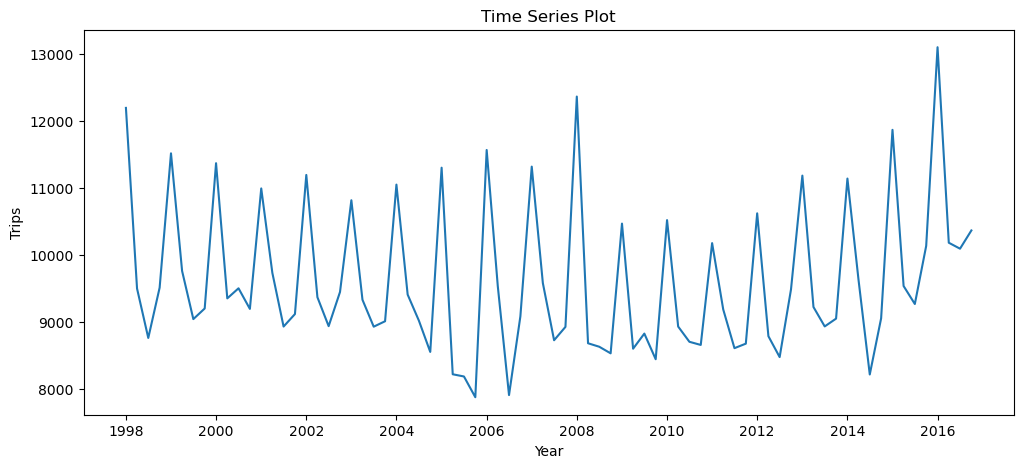


 Augmented Dickey-Fuller Test
P-value: 0.8456
Data is non-stationary
Enter the number of quarters for which data needs to be predicted:12


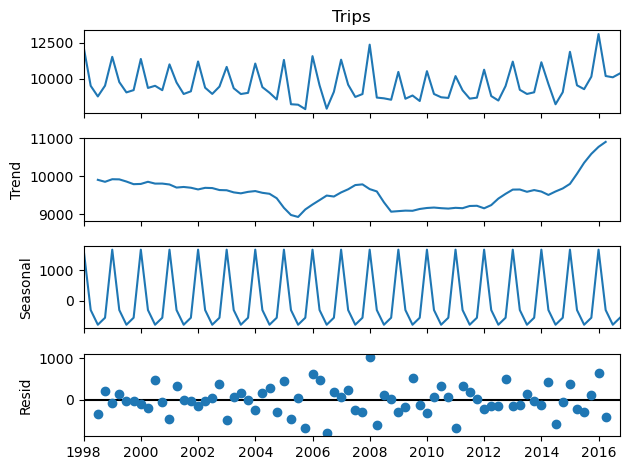

In [24]:
# Ingest Data
tourism_df = pd.read_csv(
    "C:/Users/adhwa/Downloads/archive/tourism.csv",
    usecols=["Quarter", "Purpose", "Trips"]
)
seed = 42
np.random.seed(seed)
random.seed(seed)
#  Preprocess 
aggregated_df = preprocess_tourism_data(tourism_df)
print(aggregated_df)

#  EDA 
time_series_eda(
    aggregated_df.reset_index(),
    date_col="Quarter",
    value_col="Trips"
)

# Plot seasonal decomposition
seasonal_decomposition = seasonal_decompose(aggregated_df)
seasonal_decomposition.plot();

# Train/Test Split 
train_data, test_data = train_test_split_ts(aggregated_df, train_size=64)

future_periods = int(input("Enter the number of quarters for which data needs to be predicted:"))

# SARIMA Grid Search and Prediction

Optuna took: 0:03:21.302127 to perform grid search
Auto ARIMA took: 0:00:11.415244 to perform grid search
Optuna grid search performs better
Optuna r2 value is: 0.8279817077890226
Best Params: {'p': 3, 'd': 2, 'q': 3, 'P': 0, 'D': 1, 'Q': 2, 's': 12}
Optuna RMSE: 521.03, Auto RMSE: 1066.55


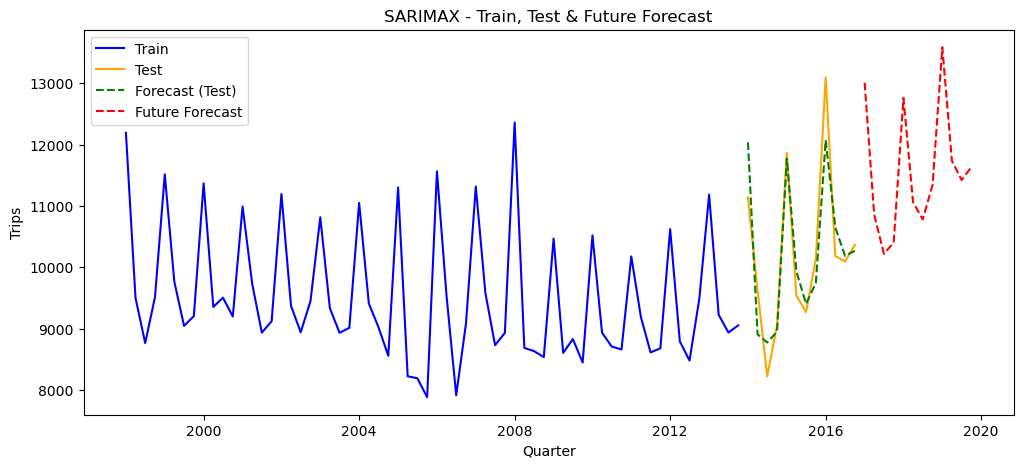

2017-01-01    13008
2017-04-01    10854
2017-07-01    10218
2017-10-01    10400
2018-01-01    12758
2018-04-01    11060
2018-07-01    10779
2018-10-01    11338
2019-01-01    13587
2019-04-01    11736
2019-07-01    11421
2019-10-01    11633
Freq: QS-JAN, Name: predicted_mean, dtype: int64


In [22]:

#  Optuna Grid Search
optuna_start = datetime.now()
sampler = optuna.samplers.TPESampler(seed=seed)
sarima_study = optuna.create_study(direction="maximize", sampler=sampler)
sarima_study.optimize(sarimax_objective, n_trials=100)
optuna_end = datetime.now()
print(f"Optuna took: {optuna_end - optuna_start} to perform grid search")

optuna_params = sarima_study.best_params.copy()

# Auto-ARIMA Grid Search
auto_arima_start = datetime.now()
auto_params = run_auto_arima(train_data)
auto_arima_end = datetime.now()
print(f"Auto ARIMA took: {auto_arima_end - auto_arima_start} to perform grid search")

# Evaluate Both grid search results on Test Data 
auto_forecast, auto_rmse, auto_r2 = sarimax_model(
    train=train_data,
    test=test_data,
    params=auto_params
)

optuna_forecast, optuna_rmse, optuna_r2 = sarimax_model(
    train=train_data,
    test=test_data,
    params=optuna_params
)

# Compare Grid Search Results
if optuna_rmse < auto_rmse and optuna_r2 > auto_r2:
    print("Optuna grid search performs better")
    print("Optuna r2 value is:",optuna_r2)
    best_model_params = optuna_params
    best_model_name = "Optuna SARIMAX"
    best_forecast_sarima = optuna_forecast
else:
    print("Auto ARIMA grid search performs better")
    print("Auto ARIMA r2 value is:",auto_r2)
    best_model_params = auto_params
    best_model_name = "Auto-ARIMA SARIMAX"
    best_forecast_sarima = auto_forecast

print("Best Params:", best_model_params)
print(f"Optuna RMSE: {optuna_rmse:.2f}, Auto RMSE: {auto_rmse:.2f}")

# --- Train Final Model on Full Data + Forecast Future ---
full_data = pd.concat([train_data, test_data])


final_forecast_sarima= sarimax_model(
    train=full_data,
    params=best_model_params,
    forecast_periods=future_periods
)

# Create future index for plotting
future_index = pd.date_range(
    start=full_data.index[-1],
    periods=future_periods,
    freq='QS'
)

# --- Plot Historical + Test Forecast + Future Forecast ---
plot_forecast(
    train=train_data,
    test=test_data,
    forecast=best_forecast_sarima,
    future_forecast=final_forecast_sarima,
    future_index=future_index,
    title="SARIMAX - Train, Test & Future Forecast"
)
print(final_forecast_sarima.round().astype(int).to_frame(name="Trips"))

# PROPHET Grid Search and Prediction

02:53:53 - cmdstanpy - INFO - Chain [1] start processing
02:53:55 - cmdstanpy - INFO - Chain [1] done processing
02:53:55 - cmdstanpy - INFO - Chain [1] start processing
02:53:56 - cmdstanpy - INFO - Chain [1] done processing
02:53:56 - cmdstanpy - INFO - Chain [1] start processing
02:53:58 - cmdstanpy - INFO - Chain [1] done processing
02:53:59 - cmdstanpy - INFO - Chain [1] start processing
02:54:00 - cmdstanpy - INFO - Chain [1] done processing
02:54:00 - cmdstanpy - INFO - Chain [1] start processing
02:54:03 - cmdstanpy - INFO - Chain [1] done processing
02:54:03 - cmdstanpy - INFO - Chain [1] start processing
02:54:05 - cmdstanpy - INFO - Chain [1] done processing
02:54:05 - cmdstanpy - INFO - Chain [1] start processing
02:54:06 - cmdstanpy - INFO - Chain [1] done processing
02:54:07 - cmdstanpy - INFO - Chain [1] start processing
02:54:07 - cmdstanpy - INFO - Chain [1] done processing
02:54:08 - cmdstanpy - INFO - Chain [1] start processing
02:54:09 - cmdstanpy - INFO - Chain [1]

02:57:14 - cmdstanpy - INFO - Chain [1] done processing
02:57:14 - cmdstanpy - INFO - Chain [1] start processing
02:57:16 - cmdstanpy - INFO - Chain [1] done processing
02:57:17 - cmdstanpy - INFO - Chain [1] start processing
02:57:19 - cmdstanpy - INFO - Chain [1] done processing
02:57:19 - cmdstanpy - INFO - Chain [1] start processing
02:57:21 - cmdstanpy - INFO - Chain [1] done processing
02:57:22 - cmdstanpy - INFO - Chain [1] start processing
02:57:23 - cmdstanpy - INFO - Chain [1] done processing
02:57:24 - cmdstanpy - INFO - Chain [1] start processing
02:57:25 - cmdstanpy - INFO - Chain [1] done processing
02:57:26 - cmdstanpy - INFO - Chain [1] start processing
02:57:27 - cmdstanpy - INFO - Chain [1] done processing
02:57:28 - cmdstanpy - INFO - Chain [1] start processing
02:57:30 - cmdstanpy - INFO - Chain [1] done processing
02:57:30 - cmdstanpy - INFO - Chain [1] start processing
02:57:32 - cmdstanpy - INFO - Chain [1] done processing
02:57:33 - cmdstanpy - INFO - Chain [1] 

Optuna took: 0:04:30.660200 to perform grid search


02:58:24 - cmdstanpy - INFO - Chain [1] start processing
02:58:26 - cmdstanpy - INFO - Chain [1] done processing
02:58:27 - cmdstanpy - INFO - Chain [1] start processing
02:58:27 - cmdstanpy - INFO - Chain [1] done processing
02:58:28 - cmdstanpy - INFO - Chain [1] start processing
02:58:28 - cmdstanpy - INFO - Chain [1] done processing
02:58:29 - cmdstanpy - INFO - Chain [1] start processing
02:58:29 - cmdstanpy - INFO - Chain [1] done processing
02:58:30 - cmdstanpy - INFO - Chain [1] start processing
02:58:30 - cmdstanpy - INFO - Chain [1] done processing
02:58:31 - cmdstanpy - INFO - Chain [1] start processing
02:58:31 - cmdstanpy - INFO - Chain [1] done processing
02:58:32 - cmdstanpy - INFO - Chain [1] start processing
02:58:32 - cmdstanpy - INFO - Chain [1] done processing
02:58:33 - cmdstanpy - INFO - Chain [1] start processing
02:58:33 - cmdstanpy - INFO - Chain [1] done processing
02:58:34 - cmdstanpy - INFO - Chain [1] start processing
02:58:34 - cmdstanpy - INFO - Chain [1]

02:59:57 - cmdstanpy - INFO - Chain [1] done processing
02:59:57 - cmdstanpy - INFO - Chain [1] start processing
02:59:59 - cmdstanpy - INFO - Chain [1] done processing
02:59:59 - cmdstanpy - INFO - Chain [1] start processing
03:00:01 - cmdstanpy - INFO - Chain [1] done processing
03:00:01 - cmdstanpy - INFO - Chain [1] start processing
03:00:03 - cmdstanpy - INFO - Chain [1] done processing
03:00:03 - cmdstanpy - INFO - Chain [1] start processing
03:00:05 - cmdstanpy - INFO - Chain [1] done processing
03:00:06 - cmdstanpy - INFO - Chain [1] start processing
03:00:07 - cmdstanpy - INFO - Chain [1] done processing
03:00:08 - cmdstanpy - INFO - Chain [1] start processing
03:00:09 - cmdstanpy - INFO - Chain [1] done processing
03:00:10 - cmdstanpy - INFO - Chain [1] start processing
03:00:12 - cmdstanpy - INFO - Chain [1] done processing
03:00:12 - cmdstanpy - INFO - Chain [1] start processing
03:00:13 - cmdstanpy - INFO - Chain [1] done processing
03:00:14 - cmdstanpy - INFO - Chain [1] 

Manual grid search took: 0:02:59.056652 to perform grid search
Manual Grid Search performs better
Manual Grid Search r2 value is: 0.22591282862458595

Best Prophet Parameters:
{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1, 'changepoint_range': 0.9}


03:01:26 - cmdstanpy - INFO - Chain [1] start processing
03:01:27 - cmdstanpy - INFO - Chain [1] done processing


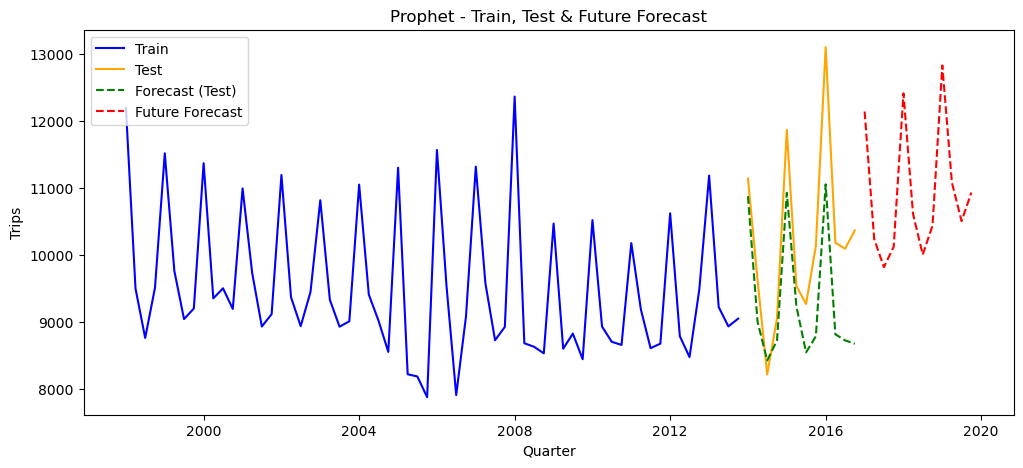

           Trips
0   12137.154213
1   10237.497531
2    9817.476330
3   10121.358604
4   12407.636038
5   10609.308624
6   10005.173362
7   10437.160996
8   12823.210672
9   11078.642193
10  10503.812182
11  10930.061152


In [46]:

#  Optuna Grid Search
prophet_sampler = optuna.samplers.TPESampler(seed=seed)
optuna_prophet_start = datetime.now()
prophet_study = optuna.create_study(
    direction="maximize", ## maximize the R2 value
    sampler=prophet_sampler
)

prophet_study.optimize(prophet_objective, n_trials=100)
optuna_prophet_end = datetime.now()
best_prophet_params_optuna = prophet_study.best_params
print(f"Optuna took: {optuna_prophet_end - optuna_prophet_start} to perform grid search")


prophet_optuna_forecast, prophet_optuna_rmse, prophet_optuna_r2 = prophet_model(
    train=train_data,
    test=test_data,
    params=best_prophet_params_optuna
)


# Manual Grid Search
manual_grid_search_prophet_start = datetime.now()
prophet_manual_forecast,best_prophet_params_manual,prophet_manual_rmse,prophet_manual_r2= prophet_manual_grid_search(
    train_data=train_data,
    test_data=test_data)
manual_grid_search_prophet_end = datetime.now()
print(f"Manual grid search took: {manual_grid_search_prophet_end - manual_grid_search_prophet_start} to perform grid search")

if  prophet_optuna_r2 > prophet_manual_r2:
    print("Optuna grid search performs better")
    print("Optuna r2 value is:",prophet_optuna_r2)
    best_prophet_params = best_prophet_params_optuna
    best_model_name = "Optuna Prophet"
    best_forecast_prophet=prophet_optuna_forecast
else:
    print("Manual Grid Search performs better")
    print("Manual Grid Search r2 value is:",prophet_manual_r2)
    best_prophet_params = best_prophet_params_manual
    best_model_name = "Manaul Grid Search Prophet"
    best_forecast_prophet=prophet_manual_forecast
print("\nBest Prophet Parameters:")
print(best_prophet_params)


final_forecast_prophet= prophet_model(
    train=full_data,
    params=best_prophet_params,
    forecast_periods=future_periods
)

# Create future index for plotting
future_index = pd.date_range(
    start=full_data.index[-1],
    periods=future_periods,
    freq='QS'
)

# --- Plot Historical + Test Forecast + Future Forecast ---
plot_forecast(
    train=train_data,
    test=test_data,
    forecast=best_forecast_prophet,
    future_forecast=final_forecast_prophet,
    future_index=future_index,
    title="Prophet - Train, Test & Future Forecast"
)
print(final_forecast_prophet)